In [1]:
from formatting_and_imports import *

### Load elevation data

In [2]:
folder = os.path.join('data', 'final_data')

# Load
eta = np.load(os.path.join(folder, 'elevation.npy')) / 1000 # Units: m. Indices: [scan #, y index, x index]
t_eta = np.load(os.path.join(folder, 'elevation_t.npy')) # Units: (s). Vector of scan times.
x_eta = (np.arange(eta.shape[2])+0.5)/100 # Units: (m). Vector of x positions (center of cell)

# Get scans as close as possible to even in log(t)
target_t = 10**np.linspace(np.log10(t_eta[1]-1), np.log10(t_eta[-1]-1), 36)

ixkeep = []
for i in range(len(target_t)):
    ixkeep.append(np.argmax(t_eta>target_t[i]))

ixkeep = np.unique(ixkeep)
eta = eta[ixkeep]
t_eta = t_eta[ixkeep]

### Plot an example scan

[]

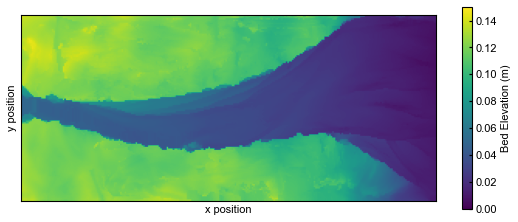

In [3]:
example_index = 10

fig, ax = plt.subplots(figsize=(9, 3.5))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
im = ax.imshow(eta[example_index], vmin=0, vmax=0.15)
cbar = plt.colorbar(im, ax=ax)
ax.set_xlabel('x position')
ax.set_ylabel('y position')
cbar.set_label('Bed Elevation (m)')
ax.set_xticks([])
ax.set_yticks([])

### Perform Flux Calculations
Sediment load is estimated from repeat scans of topography via sediment mass conservation (the Exner equation):

$$
(1-p)\frac{\partial \eta}{\partial t} = -\left(\frac{\partial q_x}{\partial x} + \frac{\partial q_y}{\partial y}\right). 
$$

Here, $p$ is the bed porosity, $\eta$ is the bed elevation, $q_x$ is the longitidunal component of the sediment flux (in the $x$ direction), $q_y$ is the lateral component of the sediment flux (in the $y$ direction), and $t$ is time. Integrating over the lateral extent of the experimental domain ($y_0$ to $y_1$) and assuming $q_y(y_0)=0$ and $q_y(y_1)=0$ leads to:

$$
(1-p)\int_{y_0}^{y_1}{\frac{\partial \eta}{\partial t} dy} = -\frac{\partial Q_s}{\partial x}
$$

where $Q_s$ is the sediment discharge in the channel, i.e.:

$$
Q_s = \int_{y_0}^{y_1}{q_x dy}
$$

Finally, integrating with respect to x gives an expression for the $Q_s$ as a function of changes in bed elevation:

$$
Q_s = -(1-p)\int_{0}^{x}\int_{y_0}^{y_1}{\frac{\partial \eta}{\partial t}} dy dx + Q_{s0}
$$

where $Q_{s0}$ is the sediment flux at $x=0$, i.e. the sediment supply. Here, $Q_{s0}=0$. 

Presently, we consider a discrete version of this expression to estimate $\overline{Q_s}(x,t_0,t_1)$, the average sediment load past the longitudinal position $x$ from two scans of topography $\eta_0$ and $\eta_1$ collected at times $t_0$ and $t_1$. If each topography scan is represented by an $m \times n$ matrix of elevation values corresponding to evenly spaced measurements in the $x,y$ plane at longitudinal resolution $\Delta x$ and lateral resolution $\Delta y$, the total sediment discharge past the point $x = n_x \Delta x$ may be estimated as: 

$$
\overline{Q_s}(x, t_0, t_1) = -(1-p) \frac{\Delta x \Delta y}{\Delta t}\sum_{i=1}^{n_x} \sum_{j=1}^m \Delta \eta_{ij}.
$$

where $\Delta \eta_{ij} = \eta_{1ij} - \eta_{0ij}$ and $\Delta t = t_1 = t_0$. Noting that the volume of sand upstream of $x$ at time $t$, $V(x, t)$, is given by

$$
V(x, t)=(1-p)\Delta y \Delta x\sum_{i=0}^{n_x} \sum_{j=0}^m \eta_{ij},
$$

the average flux $\overline{Q_s}(x,t_0,t_1)$ may be computed by comparing the volumes of sand in subsequent scans:

$$
\overline{Q_s}(x, t_0, t_1) = \frac{V(x, t_0) - V(x, t_1)}{\Delta t}
$$

This expression is used to calculate sediment discharge below. In subsequent analyses, $\overline{Q_s}(x, t_0, t_1)$ is interpreted as an instantaneous sediment discharge $Q_s(x, t)$ corresponding to the time $t=t_0+\Delta t/2$.


In [4]:
# Calculate total volume of sediment represented by each elevation measurement
dx = 0.01 # resolution = 1 cm
dy = dx
bed_porosity = 0.35

# Calculate volume of sand per longitudinal unit length (inner sum above)
v_xt = np.nansum(eta, axis=1) * (1-bed_porosity) * dy

# Calculate V(x, t) (outer sum above)
V_xt = np.cumsum(v_xt, axis=1) * dx

### Plot volume calculations

Text(0, 0.5, 'V(x, t) (m$^3$)')

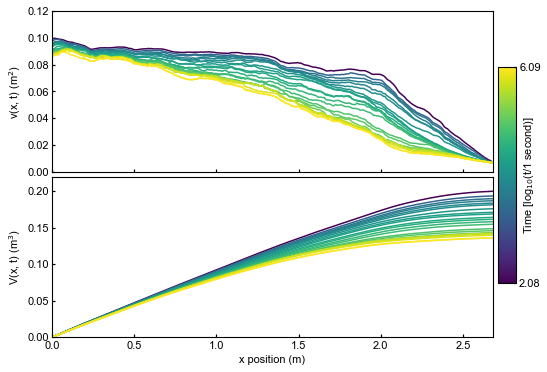

In [5]:
# Plot volume calculations
fig, ax = plt.subplots(nrows=2, figsize=(8,6), sharex=True)
plt.subplots_adjust(right=0.89, hspace=0.03)
cax = plt.axes([0.9, 0.25, 0.03, 0.5])

# make colorbar
cb1 = make_colorbar(cax, 'viridis', [0, 1], 
                    ['{:.2f}'.format(np.log10(t_eta)[0]),'{:.2f}'.format(np.log10(t_eta[-1]))], 
                    'Time [log$_{10}$(t/1 second)]',
                    labelpad=-20)

scaled_logt_eta = np.log10(t_eta) - np.nanmin(np.log10(t_eta))
scaled_logt_eta /= np.nanmax(scaled_logt_eta)

cmap = mpl.cm.viridis
for i in range(v_xt.shape[0]):
    c = cmap(scaled_logt_eta[i])

    ax[0].plot(x_eta, v_xt[i], c=c)
    ax[1].plot(x_eta+(dx/2), V_xt[i], c=c)
    

# Format axes
ax[0].set_xlim(0, 2.68)
ax[0].set_ylim(0, 0.12)
ax[0].set_ylabel(r'v(x, t) (m$^2$)')

ax[1].set_ylim(0, 0.22)
ax[1].set_xlabel('x position (m)')
ax[1].set_ylabel(r'V(x, t) (m$^3$)')

### Load and plot width data

In [6]:
# Load Width Data
Wdat = np.load(os.path.join(folder, 'width.npy')) # Units: m, indices: [photo #, x index]
t_W = np.load(os.path.join(folder, 'width_t.npy')) # vector of photo times
x_W = (np.arange(Wdat.shape[1])+0.5)/1000 # vector of x position corresponding to width measurements

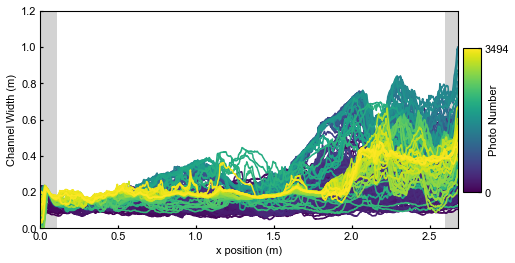

In [7]:
# Plot width data
fig, ax = plt.subplots(figsize=(8,4))
plt.subplots_adjust(right=0.85)
cax = plt.axes([0.86, 0.25, 0.03, 0.5])

# make colorbar
cb1 = make_colorbar(cax, 'viridis', [0, 1], [0, len(t_W)], 'Photo Number', labelpad=-20)

for i in range(0, Wdat.shape[0], 10): # Plot every 100th scan
    c = cmap(t_W[i]/t_W[-1])
    ax.plot(x_W, Wdat[i], c=c)
    
ax.set_xlim(0, 2.68)
ax.set_ylim(0, 1.2)
ax.set_ylabel(r'Channel Width (m)')
ax.set_xlabel('x position (m)')

# Grey bars show regions not used in our analysis
ax.fill_between([0, 0.1], [0,0], [1.2, 1.2], color='lightgrey', zorder=0)
ax.fill_between([2.6, 2.68], [0,0], [1.2, 1.2], color='lightgrey', zorder=0)

### Spatiotemporal averaging to produce final data

Next, we compute the final estimates of width and sediment discharge for analysis. Note that the measurement resolution differs between the two datatypes, but the final estimates represent an appropriate average over equivalent spatial and temporal domains.

One issue we must overcome is that the sediment discharge is estimated by differencing noisy topogrpahy data. When the changes in bed elevation between scans become small, noise in the topography data produces non-physical negative estimates of the flux. To eliminate this issue, we assume negative measured fluxes are zero. Flux is calculated using this procedure at 10 cm intervals.

In [8]:
def calculate_Qs(time, volume):
    dv = np.diff(volume)
    for i in range(len(dv)-1):
        if dv[i] > 0:
            dv[i+1]+=dv[i]
            dv[i] = np.nan
    
    if dv[-1]>0:
        dv[-1] = np.nan
    
    dt = np.diff(time)
    Qs = -dv/dt
    return Qs

x_interval = 10 # multiple of Z measurement resolution -> in this case, 10 = 10 x 1 cm
V_subsample = V_xt[:, x_interval-1::x_interval] # Get volume at 10 cm intervals
x = x_eta[x_interval-1::x_interval]+dx/2 # X coordinate of downstream edge of cells at 10 cm intervals (corresponding to volume measurement)
t = np.exp((np.log(t_eta[:-1])+ np.log(t_eta[1:]))/2) # measurement time (geometric mean)
dt = np.diff(t_eta)

# Declare arrays for final calculation
Qs = np.ones((V_subsample.shape[0]-1, V_subsample.shape[1])) * np.nan

# Calculate time series of flux for each cross section
for i in range(V_subsample.shape[1]):
    Qs[:,i] = calculate_Qs(t_eta, V_subsample[:,i])

# Create arrays of x and t, and dt values for each measurement
xarr, tarr = np.meshgrid(x, t)
_, dtarr = np.meshgrid(x, dt)

Finally, estimates of width are computed by averaging over equivalent spatial and temporal domains

In [9]:
W = np.empty_like(Qs) * np.nan
for i in range(Qs.shape[0]):
    for j in range(Qs.shape[1]):
        if ~np.isnan(Qs[i,j]):
            
            # Get temporal and spatial domain for averaging
            t0, t1 = tarr[i,j] + [-dtarr[i,j]/2, dtarr[i,j]/2] 
            x0, x1 = x[j]-x_interval*dx,  x[j] 
            
            # Calculate average width of 10 cm cell between t0 and t1
            Windex_x = (x_W > x0) & (x_W < x1) # boolean index of width measurements between x0 and x1
            Windex_t = (t_W > t0) & (t_W < t1) # boolean index of width measurements between t0 and t1
            merged_index = np.multiply(np.expand_dims(Windex_t, 1), Windex_x) # boolean array (logical AND of above)
            
            # Average width between x0 and x1, t0 and t1
            W[i,j] = np.nanmean(Wdat[merged_index])

### Define other relevant parameters

In [10]:
# Define constants
D = 0.0004          # Grain size (m)
Q = 0.16 * 1e-3     # Water discharge (m^3/s)
Cf = 0.1            # Flow resistance coefficient
tc = 0.035          # Critical stress of sediment motion
mu = 0.7            # Coulomb friction coefficient
R = 1.66            # Submerged specific gravity of sediment
g = 9.81            # Gravitational acceleration (m/s^2)
alpha=1.3           # A constant of proportionality (See equation ??)
Lx = 2.6            # Length of experimental domain (for normalization)
Qwstar = Q/np.sqrt(g * R * D**5)  # Dimensionless water discharge (constant)

# Calculate additional parameters from topography and width data
W_star = W / D                          # Dimensionless width
Qs_star = Qs/np.sqrt(g * R * D**5)      # Dimensionless sediment discharge
qs_star = Qs_star/W_star                # Dimensionless unit sediment discharge

# Compute predictions for Lacey's law and Parker (1+epsilon) model
Qs_star_vec = 10**np.linspace(-4, 3)             # list of dimensionless sediment discharges

#  Lacey's law: W = Wt (Equation ??)
Wstar_Lacey = (np.pi * np.sqrt(Cf * Qwstar/mu)/(alpha * tc**(1/4))) * np.ones(len(Qs_star_vec))
qstar_Lacey = Qs_star_vec/Wstar_Lacey
Wt = Wstar_Lacey[0] * D

# Parker River: tau* = (1+epsilon) tau*_c
qstar_Parker = (3.97 * (0.2 * tc)**(3/2)) * np.ones(len(Qs_star_vec))
Wstar_Parker = Qs_star_vec/qstar_Parker

### Figure 2: Spatiotemporal evolution of the flux

The following model provides a good fit to data between 1.2 hours and 74 hours.

$$
Q_{s}(x,t) = Q_0 (x/L)^2 e^{(-t_*/\tau)}
$$

Approximately 75\% of the total geomorphic change occurs during this interval.

In [43]:
# Fit model to exponential relaxation phase only
i0 = 2
i1 = 17
ix0 = 4

t0 = t_eta[i0] # Start of exponential phase
t1 = t_eta[i1] # End of exponential phase
x0 = x[ix0] # Skip upstream points because uncertainty is high

# Get array of values for fitting
Qs_fit = Qs[i0:i1, ix0:]
x_fit = xarr[i0:i1, ix0:][~np.isnan(Qs_fit)]
t_fit = tarr[i0:i1, ix0:][~np.isnan(Qs_fit)]
Qs_fit = Qs_fit[~np.isnan(Qs_fit)]

# Calculate relative importance of each phase in terms of total geomorphic change in the experimental domain
Qs_Deltat_out = dtarr[:,-1] * Qs[:,-1]# Time integrated sediment discharge out of experimental domain

volume_out_total = np.nansum(Qs_Deltat_out)
volume_out_initial = np.nansum(Qs_Deltat_out[:i0])
volume_out_exponential = np.nansum(Qs_Deltat_out[i0:i1])
volume_out_autogenic = np.nansum(Qs_Deltat_out[i1:])

print('Fraction of geomorphic change that occurs during initial phase: {:.03f}'.format(volume_out_initial/volume_out_total))
print('Fraction of geomorphic change that occurs during exponential phase: {:.03f}'.format(volume_out_exponential/volume_out_total))
print('Fraction of geomorphic change that occurs during autogenic phase: {:.03f}'.format(volume_out_autogenic/volume_out_total))

Fraction of geomorphic change that occurs during initial phase: 0.157
Fraction of geomorphic change that occurs during exponential phase: 0.748
Fraction of geomorphic change that occurs during autogenic phase: 0.096


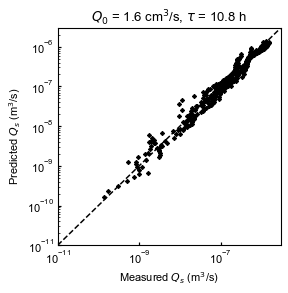

In [44]:
# Define model
def model(theta, x, t):
    gamma, tau, _ = theta
    return gamma * (x/Lx)**2 * np.exp(-t/tau)

# Define likelihood function
def log_likelihood(theta, x, t, Qs):
    gamma, tau, sigma = theta
    
    if (theta<0).any():
        return -np.inf
    else:
        prediction = model(theta, x, t)
        p = norm.pdf(np.log(Qs), np.log(prediction), sigma)
        return np.sum(np.log(p))

# Fit the model using maximum likelihood estimation
np.random.seed(42) # initialize random state for reproducibility
initial_guess = np.array([1e-6, 10000, 4]) # initial guess of model parameters
nll = lambda *args: -log_likelihood(*args) # define negative log-likelihood function for minimization
soln = minimize(nll, initial_guess, args=(x_fit, t_fit, Qs_fit)) # minimize using scipy.optimize.minimize()
Q0, tau = soln.x[:-1]
Qs_predicted = model(soln.x, x_fit, t_fit) # Generate predictions

# Visualize model fit
fig, ax = plt.subplots(figsize=(4,4))
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(Qs_fit, Qs_predicted, c='k', marker='D', lw=0, markersize=3)
ax.plot([1e-11, 3e-6], [1e-11, 3e-6], 'k--')
ax.set_xlim(1e-11, 3e-6)
ax.set_ylim(1e-11, 3e-6)
ax.set_xlabel(r'Measured $Q_s$ (m$^3$/s)')

ax.set_ylabel(r'Predicted $Q_s$ (m$^3$/s)')
_=ax.set_title(r'$Q_0$ = {:.01f} cm$^3$/s, $\tau$ = {:.01f} h'.format(soln.x[0]*1e6, soln.x[1]/3600))

In [45]:
# Define function for computing the lognormal mean and 95% confidence interval (1.96 * standard error) 
# of a samaple for plotting
def sample_stats(sample):
    sample=sample[sample>0]
    mean = np.nanmean(sample)

    std = np.nanstd(sample)
    nsamps = np.sum(~np.isnan(sample))
    CI = 1.96*std/np.sqrt(nsamps)
    low_err = CI
    up_err = CI
    return mean, [low_err, up_err]


#########################################
# Calculate quantities plotted in fig 2a
#########################################

# Normalize sediment discharge by spatial trend to highlight temporal trend (Ignore upstream data where uncerainty is large)
Qsnorm_tplot = Qs/(Q0 * (xarr/Lx)**2)

# skip upstream cells
Qsnorm_tplot_skipx = Qsnorm_tplot[:, ix0:]
t_tplot = tarr[:,ix0:]

# calculate mean and uncertainty            
mean_tplot = np.empty(Qs.shape[0])
err_tplot = np.empty([2, Qs.shape[0]])

for i in range(Qs.shape[0]):
    sample = Qsnorm_tplot_skipx[i]
    sample[np.isnan(sample)] = 0
    mean_tplot[i], err_tplot[:,i] = sample_stats(sample)

    
#########################################
# Calculate quantities plotted in fig 2b
#########################################
# Normalize sediment discharge by temporal trend to plot spatial trend (Exponential phase only)
Qsnorm_xplot = Qs/(Q0 * np.exp(-tarr/tau)) # Normalized values

# Get exponential phase only for plotting
Qsnorm_xplot_exp = Qsnorm_xplot[i0:i1]
x_xplot = xarr[i0:i1]

mean_xplot = np.empty(Qs.shape[1])
err_xplot = np.empty((2, Qs.shape[1]))
for i in range(Qs.shape[1]):
    mean_xplot[i], err_xplot[:,i] = sample_stats(Qsnorm_xplot_exp[:,i])

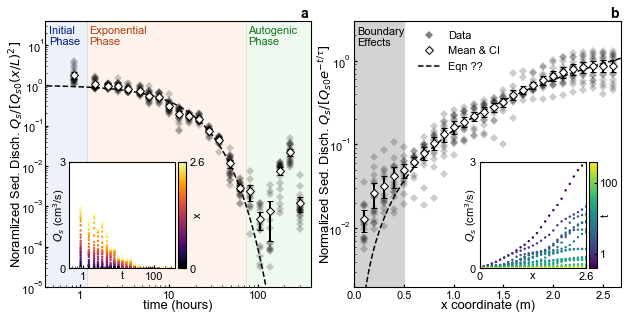

In [56]:
# Create axes
ax, axins, cax = fig2_axes(3.7)

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim(0.4, 400)
ax[0].set_ylim(1e-5, 40)

ax[0].plot(t_tplot/3600, Qsnorm_tplot_skipx, c='k', lw=0, mew=0, marker='D', alpha=0.2)
ax[0].plot(t/3600, mean_tplot, mfc='w', mec='k', marker='D', lw=0, label='Mean & CI', zorder=11)
ax[0].errorbar(t/3600, mean_tplot, err_tplot, c='k', ls='none', lw=2, capsize=3, zorder=10)

te = 10**np.linspace(2, 6, 5000)
ax[0].plot(te/3600, np.exp(-te/tau), 'k--')

ax[0].fill_between([0.2, t0/3600], [1e-5, 1e-5], [100, 100], color=sns.color_palette('muted')[0], alpha=0.1)
ax[0].text(0.4*1.12, 10, 'Initial\nPhase', color=sns.color_palette('dark')[0])

ax[0].fill_between([t0/3600, t1/3600], [1e-5, 1e-5], [100, 100], color=sns.color_palette('muted')[1], alpha=0.1)
ax[0].text(1.05*t0/3600, 10, 'Exponential\nPhase', color=sns.color_palette('dark')[1])

ax[0].fill_between([t1/3600, 400], [1e-5, 1e-5], [100, 100], color=sns.color_palette('muted')[2], alpha=0.1)
ax[0].text(1.05*t1/3600, 10, 'Autogenic\nPhase', color=sns.color_palette('dark')[2])

ax[0].set_xlabel('time (hours)', fontsize=13, labelpad=-1)
ax[0].set_ylabel(r'Noramlized Sed. Disch. $Q_s/[Q_{s0} (x/L)^2]$', fontsize=13, labelpad=-5)
ax[0].set_xticks([1, 10, 100])
ax[0].set_xticklabels([1,10,100])
ax[0].tick_params(axis='y', which='major', pad=1)

ax[1].set_xlim(0, 2.68)
ax[1].set_yscale('log')
ax[1].set_ylim(0.002, 3)
ax[1].plot(0, 0, c='grey', lw=0, mew=0, marker='D', alpha=1, label='Data')
ax[1].plot(x_xplot, Qsnorm_xplot_exp, c='k', lw=0, mew=0, marker='D', alpha=0.2)
ax[1].plot(x, mean_xplot, mfc='w', mec='k', marker='D', lw=0, label='Mean & CI', zorder=11)
ax[1].errorbar(x, mean_xplot, err_xplot, c='k', ls='none', lw=2, capsize=3, zorder=10)

ax[1].fill_between([0, x0], [0.002, 0.002], [3, 3], color='lightgrey', zorder=0)

xp = 10**np.linspace(-1,1, 5000)
ax[1].plot(xp, (xp/Lx)**2, 'k--', label='Eqn ??')
ax[1].legend(loc='upper left', bbox_to_anchor=(0.2, 1), frameon=False)

ax[1].set_xlabel('x coordinate (m)', fontsize=13, labelpad=-1)
ax[1].set_ylabel(r'Normalized Sed. Disch. $Q_s/[Q_{s0} e^{-t/\tau}]$',  fontsize=13, labelpad=-7)

ax[1].text(0.03, 1.5, 'Boundary\nEffects', color='k')

axins[0].scatter(tarr/3600, Qs, c=xarr, cmap='inferno', vmin=0, vmax=2.6, s=2)
axins[0].set_xscale('log')
axins[0].set_ylim(0, 0.000003)
axins[0].set_yticks([0, 3e-6])
axins[0].set_yticklabels([0, 3])
axins[0].set_ylabel(r'$Q_s$ (cm$^3$/s)', labelpad=-8)
axins[0].set_xlim(0.4,400)
axins[0].set_xticks([1, 10, 100])
axins[0].set_xticklabels([1, '', 100])
axins[0].set_xlabel(r't', labelpad=-11)

make_colorbar(cax[0], 'inferno', [0, 1], 
                    [0,2.6], 'x',
                    labelpad=-12)

axins[1].scatter(xarr, Qs, c=np.log10(tarr), cmap='viridis', vmin=3, vmax=6,  s=2)
axins[1].set_ylim(0, 0.000003)
axins[1].set_yticks([0, 3e-6])
axins[1].set_yticklabels([0, 3])
axins[1].set_ylabel(r'$Q_s$ (cm$^3$/s)', labelpad=-9)
axins[1].set_xlim(0, 2.6)
axins[1].set_xticks([0,2.6])
axins[1].set_xticklabels([0, 2.6])
axins[1].set_xlabel(r'x', labelpad=-11)



cb = make_colorbar(cax[1], 'viridis', 
                   [(0-np.log10(0.4))/(np.log10(400) - np.log10(0.4)), (2-np.log10(0.4))/(np.log10(400) - np.log10(0.4))], 
                   [1, 100], r't', labelpad=-18)

ax[0].text(0.96, 1.01, 'a', fontsize=14, transform=ax[0].transAxes, weight='bold')
ax[1].text(0.96, 1.01, 'b', fontsize=14, transform=ax[1].transAxes, weight='bold')


plt.savefig('figures\\fig2_raw.svg')

### Figure 3: Unstable channels obey Lacey's Law $(W=W_t)$

Load laminar channel data (Digitized from Figures 4 and 5, Abramian et al., 2019). Column names use their notation.

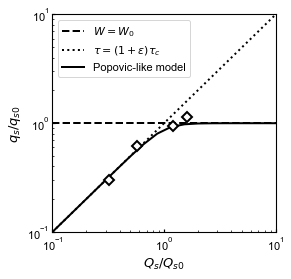

In [57]:
laminar_channels = pd.read_csv(os.path.join('data', 'final_data','abramian_2019.csv'))

Qw_lam = 1 * (1/60) * (1/1000) # (L/min) * (1m/60s) * (1 m^3 / 1000 l^3) 
rhos_lam = 1490 # sediment density(kg/m^3)
rhow_lam = 1160 # fluid density (kg/m^3)
R_lam = (rhos_lam - rhow_lam)/rhow_lam
D_lam = 0.00082 # Grain size (m)
mu_lam = 0.7 # Friction coefficient
tc_lam = 0.167 # critical Shields stress
q0_lam = 54400 # grains/m/s

laminar_channels['W_T'] = D_lam * laminar_channels['W_T/d_s']
laminar_channels['W'] = laminar_channels['W_T'] * (laminar_channels['W/W_0'] / laminar_channels['W_T/W_0'])

laminar_channels['Q_s'] = (laminar_channels['Q_s/Q_s*'] * D_lam * tc_lam * q0_lam / mu_lam) * (np.pi/6) * D_lam**3
laminar_channels['q_s'] = laminar_channels['Q_s'] / laminar_channels['W']

w0 = D_lam * laminar_channels['W_T/d_s'] / laminar_channels['W_T/W_0']
qs_p_laminar = q0_lam * (0.2 * tc_lam) * (np.pi/6)*D_lam**3

laminar_channels['qs_rel'] = laminar_channels['q_s']/qs_p_laminar
laminar_channels['Qs_rel'] = laminar_channels['Q_s'] / (qs_p_laminar * w0)

fig, ax = plt.subplots(figsize=(4,4))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-1, 1e1)
ax.set_ylim(1e-1, 1e1)
ax.set_xlabel(r'$Q_s/Q_{s0}$', fontsize=13)
ax.set_ylabel(r'$q_s/q_{s0}$', fontsize=13)

ax.plot([1e-1, 1e1], [1,1], 'k--', lw=2, label=r'$W=W_0$')
ax.plot([1e-1, 1e1], [1e-1, 1e1], 'k:', lw=2, label=r'$\tau=(1+\epsilon)\tau_c$')

Qrelvec = 10**np.linspace(-3, 3)
scale = 5
Wrel_model = Qrelvec/(Qrelvec**scale/(1+Qrelvec**scale))**(1/scale)
Wrel_model = (1+Qrelvec**scale)**(1/scale)
qsrel_model = Qrelvec / Wrel_model

ax.plot(Qrelvec, qsrel_model, 'k', lw=2, label='Popovic-like model')
ax.plot(laminar_channels['Qs_rel'], laminar_channels['qs_rel'], marker='D', lw=0, mfc='w', mec='k', ms=7, mew=2)

ax.legend()

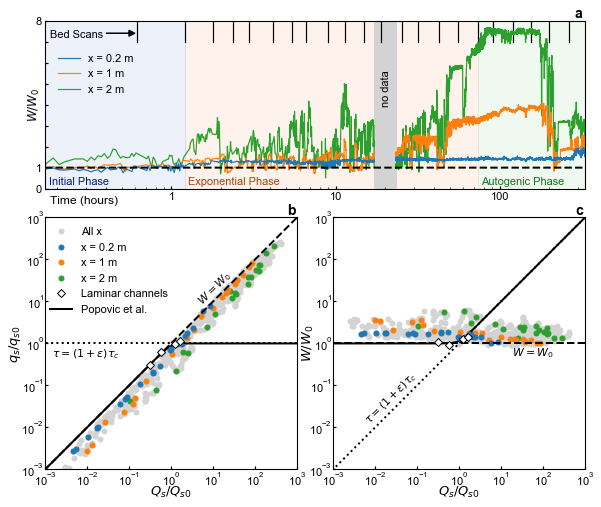

In [35]:
ax = fig3_axes(3.5)

########################################################
# Width over time
########################################################
# Time in hours
tW_h = t_W/3600

# Get index of camera error (plot separately to prevent connecting line)
ix_camera_error = np.nanmax(np.argwhere(np.diff(t_W) == np.nanmax(np.diff(t_W))))+1

# Plot before camera error
ax[0].plot(tW_h[:ix_camera_error], Wdat[:ix_camera_error, 100]/Wt, c=sns.color_palette()[0], zorder=3, label='x = 0.2 m', lw=1.2)
ax[0].plot(tW_h[:ix_camera_error], Wdat[:ix_camera_error,1000]/Wt, c=sns.color_palette()[1], zorder=2, label='x = 1 m', lw=1.2)
ax[0].plot(tW_h[:ix_camera_error], Wdat[:ix_camera_error,2000]/Wt, c=sns.color_palette()[2], zorder=1, label='x = 2 m', lw=1.2)

# Plot after camera error
ax[0].plot(tW_h[ix_camera_error:], Wdat[ix_camera_error:, 100]/Wt, c=sns.color_palette()[0], zorder=3, lw=1.2)
ax[0].plot(tW_h[ix_camera_error:], Wdat[ix_camera_error:,1000]/Wt, c=sns.color_palette()[1], zorder=2, lw=1.2)
ax[0].plot(tW_h[ix_camera_error:], Wdat[ix_camera_error:,2000]/Wt, c=sns.color_palette()[2], zorder=1, lw=1.2)

# Plot W/Wt = 1
ax[0].plot(tW_h, t_W**0, 'k--', lw=2, zorder=4)

# X axis formatting
ax[0].set_xscale('log')
ax[0].set_xlim(tW_h[0], tW_h[-1])
ax[0].text(0.01,-0.09,'Time (hours)', fontsize=12, transform=ax[0].transAxes)
ax[0].set_xticks([1, 10, 100])
ax[0].set_xticklabels([1, 10, 100])

# Y axis formatting
ax[0].set_ylim(0, 8)
ax[0].set_ylabel(r'$W/W_0$', fontsize=12, labelpad=-7)
ax[0].set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
ax[0].set_yticklabels([0,1,'','','','','','',8])

# Annotate adjustment phases
ax[0].fill_between([tW_h[0], t0/3600], [0, 0], [10, 10], color=sns.color_palette('muted')[0], alpha=0.1, zorder=0)
ax[0].fill_between([t0/3600, t1/3600], [0, 0], [10, 10], color=sns.color_palette('muted')[1], alpha=0.1, zorder=0)
ax[0].fill_between([t1/3600, 400], [0, 0], [10, 10], color=sns.color_palette('muted')[2], alpha=0.1, zorder=0)
ax[0].text(tW_h[0]*1.05, 0.2, 'Initial Phase', color=sns.color_palette('dark')[0])
ax[0].text(1.05*t0/3600, 0.2, 'Exponential Phase', color=sns.color_palette('dark')[1])
ax[0].text(1.05*t1/3600, 0.2, 'Autogenic Phase', color=sns.color_palette('dark')[2])

# Mark camera error and annotate
ax[0].fill_between(tW_h[ix_camera_error-1:ix_camera_error+1], [0, 0], [10,10], zorder=0, color='lightgrey')
ax[0].text(tW_h[ix_camera_error-1]+1.7, 4, 'no data', rotation=90, zorder=4)

# Plot scan times and annotate
ax[0].text(0.01, 0.9, 'Bed Scans', transform=ax[0].transAxes)
ax[0].arrow(0.4, 7.4, 0.15, 0, head_length=0.05, head_width=0.3, color='k')
for i in range(len(t_eta)):
    ti = t_eta[i]/3600
    ax[0].plot([ti, ti], [7, 10], 'k', lw=1.2, zorder=0)

# Other annotations
ax[0].legend(loc='lower left', bbox_to_anchor=(0.005, 0.5), frameon=False)
ax[0].text(0.98, 1.015, 'a', fontsize=14, transform=ax[0].transAxes, weight='bold')

################################################################
# Unit sediment flux vs total sediment load
################################################################
# get value of qstar_Parker for normalization
qstar_p = qstar_Parker[0]
Qstar_ref = Wstar_Lacey[0] * qstar_p

# Plot all data
ax[1].plot(Qs_star.ravel()/Qstar_ref, qs_star.ravel()/qstar_p, c='lightgrey', marker='o', markersize=5, lw=0, label='All x', zorder=0)

# Plot data from example cross-sections
ax[1].plot(Qs_star[:,0]/Qstar_ref, qs_star[:,0]/qstar_p, c=sns.color_palette()[0], marker='o', markersize=5, lw=0, label='x = 0.2 m', zorder=3)
ax[1].plot(Qs_star[:,9]/Qstar_ref, qs_star[:,9]/qstar_p, c=sns.color_palette()[1], marker='o', markersize=5, lw=0, label='x = 1 m', zorder=2)
ax[1].plot(Qs_star[:,19]/Qstar_ref, qs_star[:,19]/qstar_p, c=sns.color_palette()[2], marker='o', markersize=5, lw=0, label='x = 2 m', zorder=1)

# Plot laminar channel data
ax[1].plot(laminar_channels['Qs_rel'], laminar_channels['qs_rel'], label='Laminar channels',
           marker='D', markersize=5, lw=0, mew=1, mec='k', mfc='w', zorder=10)

# X axis formatting
ax[1].set_xlabel(r'$Q_s/Q_{s0}$', fontsize=13, labelpad=-3)
ax[1].set_xscale('log')
ax[1].set_xlim(1e-3, 1e3)
ax[1].set_xticks([1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3])
ax[1].tick_params(axis='both', which='major', pad=1)

# Y axis formatting
ax[1].set_ylabel(r'$q_s/q_{s0}$', fontsize=13, labelpad=-2)
ax[1].set_yscale('log')
ax[1].set_ylim(1e-3, 1e3)
ax[1].minorticks_off()

# Plot reference lines and annotate
ax[1].plot(Qs_star_vec/Qstar_ref, qstar_Lacey/qstar_p, 'k--', zorder=4, lw=2)
ax[1].plot(Qs_star_vec/Qstar_ref, qstar_Parker/qstar_p, 'k:', zorder=4, lw=2)
ax[1].plot(Qrelvec, qsrel_model, 'k', lw=2, label='Popovic et al.')

ax[1].text(1.46e-3, 1.1e-3/qstar_p, r'$\tau = (1+\varepsilon)\tau_c$')
ax[1].text(3.66e0, 2e-2/qstar_p, r'$W=W_0$', rotation=45)

# Legend
ax[1].legend(loc='upper left', bbox_to_anchor=(-0.02, 1), frameon=False)

# Fig letter
ax[1].text(0.96, 1.01, 'b', fontsize=14, transform=ax[1].transAxes, weight='bold')

################################################################
# Relative width vs total sediment load
################################################################
# Plot all data
ax[2].plot(Qs_star.ravel()/Qstar_ref, W.ravel()/Wt, c='lightgrey', marker='o', markersize=5, lw=0, zorder=0)

# Plot data from example cross-sections
ax[2].plot(Qs_star[:,0]/Qstar_ref, W[:,0]/Wt, c=sns.color_palette()[0], marker='o', markersize=5, lw=0, zorder=3)
ax[2].plot(Qs_star[:,9]/Qstar_ref, W[:,9]/Wt, c=sns.color_palette()[1], marker='o', markersize=5, lw=0, zorder=2)
ax[2].plot(Qs_star[:,19]/Qstar_ref, W[:,19]/Wt, c=sns.color_palette()[2], marker='o', markersize=5, lw=0, zorder=1)

# Plot laminar channel data
ax[2].plot(laminar_channels['Qs_rel'], laminar_channels['W/W_0'], 
           marker='D', markersize=5, lw=0, mew=1, mec='k', mfc='w', zorder=10)

# X axis formatting
ax[2].set_xlabel(r'$Q_s/Q_{s0}$', fontsize=13, labelpad=-3)
ax[2].set_xscale('log')
ax[2].set_xlim(1e-3, 1e3)
ax[2].set_xticks([1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3])
ax[2].tick_params(axis='both', which='major', pad=1)

# Y axis formatting
ax[2].set_ylabel(r'$W/W_0$', fontsize=13, labelpad=-7)
ax[2].set_yscale('log')
ax[2].set_ylim(1e-3, 1e3)
ax[2].minorticks_off()

# Plot reference lines and annotate
ax[2].plot(Qs_star_vec/Qstar_ref, Qs_star_vec**0, 'k--', zorder=4, lw=2)
ax[2].plot(Qs_star_vec/Qstar_ref, Wstar_Parker/Wstar_Lacey, 'k:', zorder=4, lw=2)
ax[2].plot(Qrelvec, Wrel_model, 'k', lw=2)
ax[2].text(1.83e1, 5.1e-1, r'$W=W_0$')
ax[2].text(5.12e-3, 1.27e-2, r'$\tau = (1+\varepsilon)\tau_c$', rotation=45)

# Other annotations
ax[2].text(0.96, 1.01, 'c', fontsize=14, transform=ax[2].transAxes, weight='bold')

plt.savefig('figures\\fig3_raw.svg')